In [24]:
import pandas as pd
import numpy as np
import altair as alt
from altair import datum, expr
import matplotlib.pyplot as plt
import datetime as dt
alt.renderers.enable('notebook')
pd.set_option('display.max_colwidth', -1)

In [25]:
tchrs = pd.read_stata("teacher_data.dta", convert_categoricals=False)
csos = pd.read_stata("cso_data.dta", convert_categoricals=False)
dirs = pd.read_stata("director_data.dta", convert_categoricals=False)

In [26]:
print(f"The Teacher dataset contains {tchrs.shape[0]} records\nThe CSO dataset contains {csos.shape[0]} records\nThe Director dataset contains {dirs.shape[0]} records")

The Teacher dataset contains 828 records
The CSO dataset contains 152 records
The Director dataset contains 242 records


The main questions we want to ask are documented in the [analysis plan](https://github.com/TSSlade/tusome-d4dm/blob/master/analysis_plan.md), which is an evolving document.

## Teacher Instrument

Here we begin exploring the data we obtained from interviewing the teachers.

In [27]:
tchr_ct = tchrs.shape[0]

Our dataset contains interviews with {{tchr_ct}} teachers.

### Teachers visited previously by CSOs

The underlying assumption of most of the interview protocol is that the teacher has had a coaching interaction with a CSO. The first issue we should then address is the proportion of teachers who have received a visit from a CSO.

In [28]:
never = 100 * ((tchr_ct - tchrs.vis_before.sum())/tchr_ct)

We see that {{np.round(never, decimals=2)}}% of teachers interviewed had never been previously visited by CSOs.

### Number of coaching visits in the last academic term

We have confirmed that the overwhelming majority of our teachers have been visited. We can have greater confidence in the responses they give us over the course of the interview if they have had a visit in the recent past. We therefore asked the teachers to tell us how many times they had been visited by their CSO in the preceding academic term (Term 2 of the Kenyan academic year, running from roughly May-July 2018).

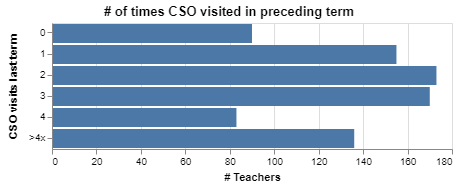

In [29]:
tchrs.vis_before_freq = tchrs.vis_before_freq.replace({55: ">4x"})
viscount_df = pd.DataFrame(tchrs.vis_before_freq.value_counts(sort=False)).rename_axis("prevterm_vis").reset_index()
viscount_df["pct"] = np.round(100 * (viscount_df.vis_before_freq / tchrs.vis_before.sum()), decimals=2)
more_than_monthly = viscount_df[viscount_df.prevterm_vis.isin([4, ">4x"])].pct.sum()
alt.Chart(viscount_df, title="# of times CSO visited in preceding term").mark_bar().encode(
    alt.Y("prevterm_vis:O", title="CSO visits last term"),
    alt.X("vis_before_freq:Q", title="# Teachers"),
    tooltip="pct")

We see that roughly {{int(viscount_df[viscount_df.prevterm_vis==0].pct[0])}}% of the respondents, while they'd been visited by a CSO in the past, had not been visited in the preceding term. However, roughly {{int(viscount_df[viscount_df.prevterm_vis.isin([1, 2, 3])].pct.sum())}}% of the respondents were visited between once per term and once per month. Roughly {{int(more_than_monthly)}}% of the teachers were visited by their CSOs more frequently than monthly.

### CSOs' activities during last coaching visit

We are interested in knowing what CSOs are focusing on when they pay a visit to a school. Are they observing a lesson? Are they giving feedback to the teacher? Do they assess pupils' fluency rates? Do they take advantage of their presence at the school to meet with the head teacher (HT)? What kinds of things are they doing _besides_ these activities?

In [30]:
visact_df = pd.DataFrame.from_dict({"activities": ["Assessed pupils",
                                                   "Talked to HT",
                                                   "Provided feedback on lesson",
                                                   "Had general talk",
                                                   "Other"],
                                    "tchrs_reporting": [tchrs[tchrs.vis_before != 0].vis_act_kids.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_ht.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_fdbk.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_gen.sum(),
                                                        tchrs[tchrs.vis_before != 0].vis_act_other.sum()]})
visact_df["pct"] = np.round(visact_df.tchrs_reporting.apply(lambda x: 100 * (x/(tchr_ct - never))), decimals=2)
visact_df

,activities,tchrs_reporting,pct
0,Assessed pupils,688,83.84
1,Talked to HT,516,62.88
2,Provided feedback on lesson,734,89.44
3,Had general talk,364,44.36
4,Other,127,15.48


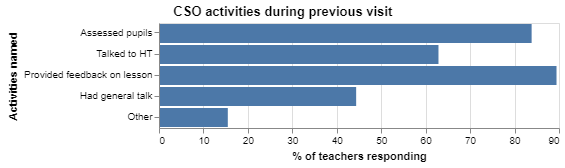

In [31]:
alt.Chart(visact_df, title="CSO activities during previous visit").mark_bar().encode(
alt.Y("activities:O", 
      title="Activities named",
      sort = alt.EncodingSortField(field="tchrs_reporting", op="values", order="ascending")),
alt.X("pct:Q",
      title="% of teachers responding"),
tooltip = "tchrs_reporting")

Nearly {{int(np.ceil(visact_df.pct.max()))}}% of teachers report that when the CSO last visited, s/he provided feedback on a lesson. A fairly comparable proportion said that the CSO assessed pupils. Neither of these is surprising, as those activities are key features of a "reimbursable" or "valid" lesson observation. If anything, it is interesting that these numbers are not higher, given that we have excluded from our denominator those teachers who said they had never received a visit from the CSO.

Of note is the relatively low proportion of teachers reporting the CSO had spoken with the HT. While Tusome encourages CSOs to speak with HTs as part of the standard protocol for visiting a school, it is not explicitly considered as a factor for reimbursement of transportation costs for visiting that school.

That said, it is also possible that teachers may simply not be aware of activities taking place outside of their classroom. They and their classrooms would have been the objects of the lesson observation and fluency assessment; they may not have as much visibility into what happened before or after the CSO entered their classroom.

A little over {{int(np.floor(visact_df[visact_df.activities=="Other"].pct))}}% of teachers reported the CSO conducted an activity that was not listed in the questionnaire. Below we have sampled 20 of the things that they reported which were not captured in the questionnaire.

In [32]:
print(tchrs[tchrs.vis_act_other_det.notna() & (tchrs.vis_act_other_det != "")].vis_act_other_det.sample(20))

698    spoke to head teacher,assesed pupils and gave me feedback                                                                                                                                              
734    The CSO assesssed me teaching tusome lessons and gave me feedback and at the same time he assessed three of my learners whom he picked randomly                                                        
259    she requests for professional documents before starting to observe the lesson this includes lesson plans and schemes of work. she also inquires where i have challenges in regards to my profession    
349    Talked about implementation of Maths                                                                                                                                                                   
74     Checked on CBC infusion                                                                                                                                              

### CSOs using tablets or pen & paper during observation

The _Tangerine:Tutor_ app was developed with the intent and belief that CSOs would use it _while observing_ the lesson. However, Tusome staff report that not all CSOs find the tablet interface comfortable, and not all use it with ease. So we asked teachers to report whether CSOs use the tablets during the lesson observation, and also whether they use pen and paper.

Roughly {{int(np.round(100 * (tchrs.cso_usetab_yn.sum()/tchr_ct), decimals=2))}}% of teachers reported that the CSOs use tablets during lesson observation; roughly {{int(np.round(100 * (tchrs.cso_usepcl_yn.sum()/tchr_ct), decimals=2))}}% of teachers reported the CSOs use pen and paper during the lesson observation.

In [33]:
tabs_n_pencils = pd.crosstab(tchrs.cso_usetab_yn, tchrs.cso_usepcl_yn)

In [34]:
# tabs_n_pencils.rename(columns=["No pen", "Uses pen"])
tabs_n_pencils = tabs_n_pencils.rename_axis("Uses tablet").rename_axis("Uses pen and paper", axis="columns")
tabs_n_pencils = tabs_n_pencils.rename({0: "No", 1: "Yes"}, axis="columns").rename({0: "No", 1: "Yes"}, axis="index")
tabs_n_pencils

Uses pen and paper,No,Yes
Uses tablet,,
No,3,17
Yes,72,657


We see that the overwhelming majority of CSOs are using both tablets _and_ pen-and-paper systems when observing the teachers' lesson. There have historically been some instruments/data that CSOs were tasked by TSC to complete that were not rendered in _Tangerine_ format on the tablets; as of midway through Term 3 of the 2018 academic year, those instruments (mostly for the TSC's TPAD \[Teacher Performance Appraisal and Development\] project) are now in _Tangerine_. While the use of pen and paper does not appear to have come at the expense of using the tablets - indeed, it appears to be complementary, as nearly all CSOs are using both - Tusome should nonetheless follow up on these reports of CSOs' usage of pen and paper to understand the roots of the practice.

### CSOs' usage of the tablets to assess pupils' performance

Tusome's coaching protocol requires CSOs to randomly select three children from the classroom at the end of the lesson to assess their reading fluency. The prompt the children are to read from is a laminated sheet of paper with a short passage printed on it; the CSOs are instructed to use the tablet to record the children's responses. The tablet is then able to calculate fluency rates and store those as data associated with that observation.

Approximately {{int(np.round(100 * (tchrs.cso_usetab_pup_yn.sum()/tchr_ct), decimals=2))}}% of the teachers reported that CSOs use the tablets to assess children's reading fluency.

### Teachers' experience of feedback, and CSOs' use of tablets during feedback

Tusome asked teachers whether the CSO gave feedback on the lesson last time s/he paid a visit, whether s/he used the tablet to do so, and whether the teacher was able to recall specific feedback the CSO provided.

In [35]:
feedback = {"CSO gave feedback": tchrs.cso_gave_fdbk_yn.sum(),
            "CSO used a tablet for feedback": tchrs.cso_usetab_fdbk_yn.sum(),
            "Tchr remembers feedback": tchrs.cso_fdbk_remember.sum()}
fdbk_df = pd.DataFrame.from_dict(feedback, orient="index", columns=["ct"])
fdbk_df["pct"] = 100 * np.round(fdbk_df["ct"] / tchrs.shape[0], decimals=3)
fdbk_df = fdbk_df.rename_axis("event").reset_index()
fdbk_df

,event,ct,pct
0,CSO gave feedback,757.0,91.4
1,CSO used a tablet for feedback,676.0,81.6
2,Tchr remembers feedback,725.0,87.6


Below we have sampled 20 of the things that they reported which were not captured in the questionnaire.

In [36]:
print(tchrs[tchrs.cso_fdbk_det.notna() & (tchrs.cso_fdbk_det != "")].cso_fdbk_det.sample(20))

151    reinforced my understanding on the things i had done well during teaching,told me to follow the steps of teaching comprehension/ predictions, advised me on how to ensure that all pupils read to the expected fluency                                                                                                                                                                                         
287    Pupils observe punctuaction martks during reading, correct articulation of sound /u/                                                                                                                                                                                                                                                                                                                           
595    He majorly talked on infusion and told me to improve in infusing CBC. I didn't do it quite well.                                                                                   

The tablets come equipped with various aids that CSOs could use to help coach teachers. In addition to the contents of the auto-generated feedback, CSOs could use the _Papaya_ application to model pronunciation of letter sounds, the videos demonstrating effective lesson delivery, etc. Of the teachers reporting CSOs provided feedback of some kind, {{int(100* (tchrs.cso_fdbk_showtab_yn.sum() / tchrs.vis_act_fdbk.sum()))}}% indicated that the CSO showed them something directly on the tablet.

In [37]:
fdbk_shown_df = pd.DataFrame.from_dict({"resources": ["Tips from feedback screen",
                                                   "Pupils' reading fluency",
                                                   "Videos of lesson delivery",
                                                   "Letter sounds in Papaya",
                                                   "Other"],
                                    "tchrs_reporting":[
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_tips.sum(),
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_fluency.sum(),
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_video.sum(),
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_lsnd.sum(),
                                        tchrs[tchrs.vis_act_fdbk != 0].cso_shw_other.sum()]})
fdbk_shown_df["pct"] = np.round(
    fdbk_shown_df.tchrs_reporting.apply(
    lambda x: 100 * (x/visact_df[visact_df.activities=="Provided feedback on lesson"].tchrs_reporting)),
    decimals=2)
fdbk_shown_df

,resources,tchrs_reporting,pct
0,Tips from feedback screen,167,22.75
1,Pupils' reading fluency,260,35.42
2,Videos of lesson delivery,128,17.44
3,Letter sounds in Papaya,230,31.34
4,Other,54,7.36


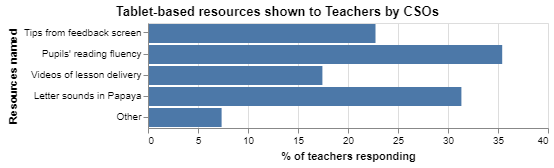

In [38]:
alt.Chart(fdbk_shown_df, title="Tablet-based resources shown to Teachers by CSOs").mark_bar().encode(
alt.Y("resources:O", 
      title="Resources named",
      sort = alt.EncodingSortField(field="tchrs_reporting", op="values", order="ascending")),
alt.X("pct:Q",
      title="% of teachers responding"),
tooltip = "tchrs_reporting")

Overall, fewer than 50% of teachers indicated that CSOs showed them something on the tablet as part of the feedback session. Where the CSO showed something to the teacher, it was most frequently pupils' reading fluency (at {{int(fdbk_shown_df[fdbk_shown_df.resources=="Pupils' reading fluency"].pct)}}%), with Papaya letter sounds the next most common (at {{int(fdbk_shown_df[fdbk_shown_df.resources=="Letter sounds in Papaya"].pct)}}%).

**N.B.**: <span style="color:red"> Update cell w literate programming re: which activity is in the lead. (Abstract one level further.)</span>

Below we have sampled 20 of the things that they reported which were not captured in the questionnaire.

In [39]:
print(tchrs[tchrs.cso_shw_other_det.notna() & (tchrs.cso_shw_other_det != "")].cso_shw_other_det.sample(20))

245    She showed me how the lesson the is arranged from her teachers guide on the tablet                                              
225    He showed me Lesson Duration and areas of improvements                                                                          
733    The CSO showed me the duration i took while teaching the lesson and the number of words read by the learners that were assesssed
640    fluecny level and played letter sound                                                                                           
601    Some of the words that most learners didn't read correctly during pupils assessment                                             
257    lesson duration, sometimes she does show me areas highlighted for improvement directly from the tablets                         
275    Lesson duration                                                                                                                 
676    in matehematics, he showed me a step in h

### CSOs' use of feedback visit-over-visit

Tusome's theory of change stipulates that smaller, more frequent, and more targeted coaching interactions will shift teacher behavior more effectively than larger-scale, episodic training events that cover a broad range of topics. This is the reason Tusome invests so heavily in supporting CSOs to provide coaching support to teachers in the span between large-scale training events.

Teachers, like most people, will be more likely to alter their behavior if feedback is timely and consistent, and the teachers' response to it is monitored rather than assumed. In this survey, roughly {{int(100 * (tchrs[tchrs.vis_before != 0].cso_ref_prev_fdbk_yn.sum()/tchrs.vis_before.sum()))}}% of teachers indicated that when CSOs visited the school and observed the teacher, they follow up on feedback from earlier visits.

**T.D.**: <span style="color:red"> Update cells so definitions of variable `literate programming` inputs are visible.</span>

### Teachers self-reported improvement in response to coaching

Effectively measuring the quality of instruction or lesson delivery is a very, very difficult task. (**T.D.**: <span style="color:red"> Provide citations, examples of various approaches.</span>)

The current study was not able to directly assess the quality of teachers' lesson delivery, although Tusome is working on various other studies which attempt to do so. However, we asked teachers whether they felt the coaching received from CSOs had improved the quality of their teaching. We first posed the question in regard to the teaching of reading in Kiswahili and English, and then asked them whether the coaching had improved their teaching in other subjects as well.

In [40]:
better_tchr_df = pd.DataFrame.from_dict(
    {"subject": ["Kiswahili & English reading",
                  "Other subjects"],
     "tchrs_reporting": [tchrs[(tchrs.vis_act_fdbk != 0) &
                                (tchrs.vis_before != 0)].cso_fdbk_better_tus.sum(),
                          tchrs[(tchrs.vis_act_fdbk != 0) &
                                (tchrs.vis_before != 0)].cso_fdbk_better_nont.sum()]})
better_tchr_df["pct"] = np.round(
    better_tchr_df.tchrs_reporting.apply(
    lambda x: 100 * (x/tchrs[(tchrs.vis_act_fdbk !=0) & (tchrs.vis_before != 0)].vis_before.sum())),
    decimals=2)

bttr_tus_pct = better_tchr_df[better_tchr_df.subject=="Kiswahili & English reading"].pct
bttr_nont_pct = better_tchr_df[better_tchr_df.subject=="Other subjects"].pct
better_tchr_df

,subject,tchrs_reporting,pct
0,Kiswahili & English reading,732.0,99.86
1,Other subjects,706.0,96.32


Encouragingly, {{float(bttr_tus_pct)}}% and {{float(bttr_nont_pct)}}% - effectively all - teachers have indicated that the feedback they receive from CSOs has enabled them to be better teachers.

Below we have sampled 20 of the examples teachers gave for how their teaching has improved as a result of the feedback.

In [56]:
print(tchrs[tchrs.cso_fdbk_better_det.notna() & (tchrs.cso_fdbk_better_det != "")].cso_fdbk_better_det.sample(20))

643    I had a problem with the pronounciation of sound/w/ and he corrected me using the sounds from the tablet                                                                                                                                                                                                           
317    use the method to teach other classes I teach in upper.                                                                                                                                                                                                                                                            
716    It has helped me improve Hygiene and Nutrition, Religious, Maths activities                                                                                                                                                                                                                                        
686    when teaching comprehension ensure that pupils r

### CSOs' discussion of pupil fluency

The ultimate goal of Tusome is to improve reading outcomes in grades 1-3. Whether the project has been successful is determined by the pupils' reading skills (with an emphasis on _oral reading fluency_, or ORF, and reading comprehension) as demonstrated by their performance on an early grade reading assessment (EGRA).

For a CSO's visit to be considered _complete_ or _valid_, one of the criteria is that it include an assessment of the reading skills of three randomly-selected pupils. These pupils are then provided a stimulus that contains a brief reading passage of ~50-100 words. As they read aloud from the stimulus, the CSO uses the _Tangerine_ application on the tablet to make note of any inaccurately read words. When the child has finished reading - or when 60 seconds elapses, whichever comes first - the assessment is complete. The child's fluency is then calculated using the formula

$$\frac{\text{# of correct words}}{\big(\frac{60 \ - \ \text{time remaining (s)}}{60}\big)} = \text{correct words per minute}$$

The _Tangerine_ software calculates the average fluency in _cwpm_ across all three pupils and reports it as part of the lesson feedback. The CSO is able - but not required - to bring up the pupils' fluency as part of their feedback session.

In [62]:
fluency_disc_df = pd.DataFrame.from_dict({"response": [
    "CSO discusses fluency in feedback session",
    "Teacher finds discussion of fluency useful"],
    "tchrs_responding": [
        tchrs[tchrs.vis_before != 0].cso_fdbk_discfluency.sum(),
        tchrs[tchrs.vis_before != 0].cso_fdbk_flu_useful.sum()]})

fluency_disc_df["pct"] = np.round(100 * 
                        fluency_disc_df.tchrs_responding.apply(
                            lambda x: x / (tchrs.vis_before.sum())), decimals=2)

flu_cso_disc = fluency_disc_df[fluency_disc_df.response=="CSO discusses fluency in feedback session"].pct
flu_disc_use = fluency_disc_df[fluency_disc_df.response=="Teacher finds discussion of fluency useful"].pct
fluency_disc_df

,response,tchrs_responding,pct
0,CSO discusses fluency in feedback session,706.0,92.05
1,Teacher finds discussion of fluency useful,710.0,92.57


It appears the overwhelming majority of CSOs ({{float(flu_cso_disc)}}%) discuss the pupils' fluency with the teachers, and the teachers overwhelmingly ({{float(flu_disc_use)}}%) find it a useful discussion. But how do teachers make use of that insight?

Below we have sampled 20 of the examples teachers gave for what they do with knowledge of their pupils' fluency rates.

In [63]:
print(tchrs[tchrs.cso_fdbk_flu_dowith.notna() & (tchrs.cso_fdbk_flu_dowith != "")].cso_fdbk_flu_dowith.sample(20))

119    I use the information to assist slow/non-readers and encourage them work in groups of mixed ability for peer support                                                                                                                                       
191    I work extra hard especially on weak learners so as to improve their fluency, for strong learners, i normally give them more materials to read.                                                                                                            
49     I do remedial classes for those children who are not able to read                                                                                                                                                                                          
551    I use this information to encourage the slow learners to improve by giving them more practice on reading..                                                                                                              

### Disruption caused by tablet use

Pupils are easily distracted by the presence of unfamiliar adults in the classroom. However, if the adult sits quietly and unobtrusively in the rear of the classroom, the children rapidly become acclimated to the visitor's presence and are able to focus on the lesson.

For many children in rural schools, however, tablet computers are an unfamiliar sight. Tusome was interested to know whether the CSOs' use of tablets to conduct the classroom observation or assess the pupils' fluency is perceived as disruptive.

In [75]:
tchr_dist_df = pd.DataFrame.from_dict({
    "case": [
        "CSO tablet use for observation",
        "CSO tablet use for feedback"],
    "distracting": [
        tchrs[tchrs.vis_before != 0].cso_tab_distract_yn.sum(),
        tchrs[tchrs.vis_before != 0].cso_tab_fdbk_distrac.sum()]})

tchr_dist_df["pct"] = 100 * np.round(tchr_dist_df.distracting.apply(
    lambda x: x / tchrs.vis_before.sum()),
             decimals=2)

distracting_tab_obs = float(tchr_dist_df[tchr_dist_df.case=="CSO tablet use for observation"].pct)
distracting_tab_fdbk = float(tchr_dist_df[tchr_dist_df.case=="CSO tablet use for feedback"].pct)

tchr_dist_df

,case,distracting,pct
0,CSO tablet use for observation,34.0,4.0
1,CSO tablet use for feedback,16.0,2.0


Reassuringly, very few teachers responded that they find it distracting when the CSO used a tablet during observation or during feedback ({{distracting_tab_obs}}% and {{distracting_tab_fdbk}}%, respectively). It is worth considering why they found the tablet use distracting; because the numbers are so low, the lists below present all responses rather than just a sample.

In [77]:
print(tchrs[(tchrs.cso_tab_distract_why != "") & tchrs.cso_tab_distract_why.notna()].cso_tab_distract_why)

1      Pupils get attention of the tablet                                                                                                                                                          
13     at times it is distracting when the CSO takes a photo using the tablet. This mostly affects the pupils. It was a challenge to me the first time she took the photos but now I am used to it.
26     some learners look at the CSO at the back of the class as he he uses tablet hence distracting their attention                                                                               
47     The curious one always keep on looking at the tablet instead of listening to me                                                                                                             
89     Some of the children sitting next to the children get distraccted and stop looking and the board.They are are also not comfortable because they are not used to it.                         
108    N/A s        

In [78]:
print(tchrs[(tchrs.cso_fdbk_tab_diswhy != "") & tchrs.cso_fdbk_tab_diswhy.notna()].cso_fdbk_tab_diswhy)

35     it arouses curiosity therefore disrupt concentration of the learners                                                                                                                                                                                                         
50     I am distracted because i don't know what he will tell me                                                                                                                                                                                                                    
176    Because i am not aware what he is doing with the tablet but if both are looking at it, i will not find it distracting                                                                                                                                                        
206    My thinking is that the CSO is recording me and can be used in other places                                                                                       

While these results are encouraging, it may be that CSOs' tablet use is more distracting when it is the pupils themselves who are the object of the CSO's attention. We asked teachers whether they were present during the assessment of pupils' reading skills, and if so, whether it was their sense that pupils were distracted by the tablet use.

In [112]:
pupil_dist_df = pd.DataFrame.from_dict({
    "response": [
        "Teacher observed the assessment",
        "Pupils found the tablet distracting"],
    "tchrs_responding": [
        int(tchrs[tchrs.vis_before != 0].cso_pres_ass_tab.sum()),
        int(tchrs[tchrs.vis_before != 0].cso_pup_distract_ass.sum())]})

pupil_dist_df["numerator"] = [
    int(tchrs.vis_before.sum()),
    int(pupil_dist_df[pupil_dist_df.response=="Teacher observed the assessment"].tchrs_responding)]

pupil_dist_df["pct"] = 100 * np.round(pupil_dist_df.tchrs_responding / pupil_dist_df.numerator, 2)

tchrs_obsd_assmt = int(pupil_dist_df[pupil_dist_df.response=="Teacher observed the assessment"].pct)
pupils_distracted = int(pupil_dist_df[pupil_dist_df.response=="Pupils found the tablet distracting"].pct)

pupil_dist_df

,response,tchrs_responding,numerator,pct
0,Teacher observed the assessment,449,767,59.0
1,Pupils found the tablet distracting,98,449,22.0


Roughly {{tchrs_obsd_assmt}}% of the teachers said they had observed the CSO's assessment of the pupils' reading skills. Of those, {{pupils_distracted}}% thought the pupils found the tablet distracting. This may suggest a need for Tusome to provide additional training or orientation to CSOs on best practices in assessment administration.

Below we sample 20 of the reasons teachers provided for why they thought pupils found tablet use distracting during the assessment.

In [115]:
print(tchrs[(tchrs.cso_pup_dist_why != "") & tchrs.cso_pup_dist_why.notna()].cso_pup_dist_why.sample(20))

245    In class 1 the pupils look more at the tablet than the stimulus which affects the reading ability of the child. Sometimes the pupils just look at the tablets because they havent seen such a tablet before so they focus more on the tablet. The stimulus is also distracting because pupils are used to reading books. Small children are not used to new people so by the time they get used to the CSO, they fear her a lot affecting their reading.
687    They wanted to see what she was doing                                                                                                                                                                                                                                                                                                                                                                                                                   
440    Pupils want to see what he is typing in the tablet                                               

### Teachers' ongoing assessment of pupil fluency

Teachers are fully capable of assessing their pupils' reading fluency without recourse to a tablet. However, RTI has experimented with an Android-based pupil performance tracking tool that might be of use to teachers. Therefore we were interested to understand the extent to which teachers are already assessing pupils' fluency, what tools they are using for the task, whether they have access to phones on which such a tool could be deployed, and whether they would want to use it if so.

In [117]:
tchrs_assessing = 100 * np.round(tchrs.tchr_ass_pup_flu_yn.sum() / tchrs.shape[0], decimals=2)

Roughly {{int(tchrs_assessing)}}% of teachers we spoke to indicated they assess their pupils' fluency. When asked to specify what tools they use for the task, they specified the following.

{{print(tchrs[(tchrs.tchr_ass_pup_flu_yn != 0) & (tchrs.tchr_ass_pup_tools != "") & tchrs.tchr_ass_pup_tools.notna()].tchr_ass_pup_tools.sample(20))}}

In [119]:
print(tchrs[(tchrs.tchr_ass_pup_flu_yn != 0) & (tchrs.tchr_ass_pup_tools != "") & tchrs.tchr_ass_pup_tools.notna()].tchr_ass_pup_tools.sample(20))

302    I use reading materials like story books                                                                                                                                                                                                                                                                                                                                     
438    i give pupils flash cards which I have put in a box and they read even the sounds,sometimes I give them paper articles to read/simple magazines\r                                                                                                                                                                                                                            
509    give them words and short sentences to read for me                                                                                                                                                                                                     

In [123]:
tang_tool_df = pd.DataFrame.from_dict({
    "response": ["Teacher has a phone",
                 "Phone is an Android",
                 "Teacher would like a tool"],
    "tchrs_responding": [
        tchrs.tch_mob_phone.sum(),
        tchrs.tch_has_android.sum(),
        tchrs.tch_wants_assess.sum()]})

tang_tool_df["pct"] = 100 * np.round(tang_tool_df.tchrs_responding.apply(lambda x: x / tchrs.shape[0]), decimals=2)
tang_tool_df

,response,tchrs_responding,pct
0,Teacher has a phone,814.0,98.0
1,Phone is an Android,654.0,79.0
2,Teacher would like a tool,813.0,98.0


Nearly all teachers interviewed indicated they have access to a mobile phone; nearly 4 out of 5 teachers indicated their phone is an Android. Nearly all teachers - even those who don't have an Android - said they would like to have access to a tool that would provide them sample assessments they could do with their pupils.

## CSO Instrument

Here we begin exploring the data we obtained from interviewing the CSOs.

### Length of experience using tablet-based Tangerine
_When did you first receive a tablet from Tusome or PRIMR?_

We want to convert the year/month CSOs provided into a number so we can work with it easily. We'll make the simplifying assumption that the tablet was received on the first day of the month they provided, and that this interview was conducted on the first day of the month. Neither of those are true, but the marginal days are unlikely to make a practical difference in a CSO's facility with the tool.

In [41]:
now = dt.datetime(2018, 10, 1)
csos["tab_usage"] = pd.to_timedelta(now - pd.to_datetime({"year": csos.recd_tab_yr, "month": csos.recd_tab_month, "day": 1})).dt.days

We'll also want to convert the duration to months, since that will be easier to digest, and filter out any missing values.

In [42]:
tab_usage = pd.DataFrame(csos[csos.tab_usage.notna()].tab_usage / 30)
# tab_usage

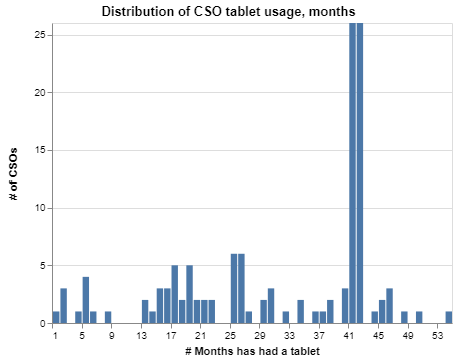

In [43]:
alt.Chart(tab_usage, title="Distribution of CSO tablet usage, months").mark_bar().encode(
    alt.X("tab_usage:Q", 
          bin=alt.BinParams(step=1), title="# Months has had a tablet"),
    alt.Y("count()", title="# of CSOs"))

We see that the majority of our CSOs have had their tablets for roughly {{int(tab_usage.tab_usage.mode()[0])}} months ({{np.round(tab_usage.tab_usage.mode()[0]/12, decimals=1)}} years). This is in keeping with the beginning of the Tusome program, and is as expected. CSOs who have had their tablets for longer are likely veterans of the PRIMR program (Tusome's predecessor); those who have had tablets for fewer months may have assumed their roles more recently. (CSO turnover due to retirement, promotion, maternity leave, etc. is an issue which Tusome is constantly needing to manage.)

### Proportion of CSOs reporting use of each application

_Which applications do you use frequently when supporting teachers? ...After recording unprompted responses, read the list of options and record responses._
  + Tangerine Tutor
  + Papaya
  + Tusome Books (in Adobe Acrobat)
  + Tusome Videos (in MX Player)

The CSOs' tablets come equipped with several tools meant to support their efforts as instructional coaches. These include the [_Tangerine:Tutor_](http://www.tangerinecentral.org/tutor/) application, the [_Papaya_](http://schoolsnetkenya.com/tusome-early-literacy-programme-sounds-application/) application, PDF versions of Tusome's instructional materials (pupil's books and teacher's guides), and videos that model effective instructional delivery.

We are interested in which of those tools CSOs use, and how frequently. We will provide an analysis of their unprompted free-response answers to the question above. For the moment, we note the tools they said they use when we explicitly prompted them with the list of tools available.

In [44]:
app_users = {"tutor": csos.freqapps_tt_promp.sum(),
         "papaya": csos.freqapps_papaya_promp.sum(),
         "books": csos.freqapps_bks_promp.sum(),
         "videos": csos.freqapps_vids_promp.sum()}
app_usage = pd.DataFrame.from_dict(app_users, orient="index", columns=["ct"])
app_usage["pct"] = 100 * np.round(app_usage["ct"] / csos.shape[0], decimals=3)
app_usage = app_usage.rename_axis("app").reset_index()

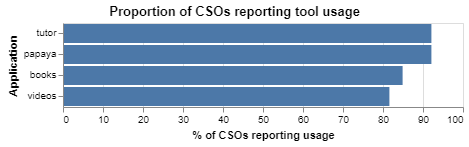

In [45]:
alt.Chart(app_usage, title="Proportion of CSOs reporting tool usage").mark_bar().encode(
    alt.Y("app:O",
          title="Application",
          sort = alt.EncodingSortField(field="pct", op="values", order="ascending"),
          ),
    alt.X("pct:Q", title="% of CSOs reporting usage"),
    tooltip="pct")

The overwhelming majority of the CSOs report using all of the applications. That said, the videos and books are used less frequently.

### Proportion of CSOs who refer to Tangerine to provide post-observation feedback

_Do you refer to Tangerine when giving teachers feedback after observing a lesson?_

The _Tangerine:Tutor_ application analyzes the pattern of the CSO's responses to the observation items and surfaces actionable feedback that could be share with the teacher to improve her or his instruction. While the auto-generated feedback is intended as a tool to help CSOs give more effective guidance to teachers, it can be quite extensive and is not prioritized. We were interested to know whether the CSOs make reference to the application's auto-generated feedback when they hold their post-observation debriefing session with the teacher.

In [46]:
100 * np.round(csos.ref_tang_fdbk.sum() / csos.shape[0], decimals=3)

96.7

Again, the overwhelming majority of CSOs report using the auto-generated feedback when holding their debrief session with the teacher. We will separately provide an analysis of their open-ended answers regarding _what_ they refer to and what they find most useful.

### Proportion of CSOs who use Tangerine to plan their work

_Do you refer to Tangerine to help you plan your work when you are **not** either observing a teacher or giving the teacher feedback?_

Version 3 of the _Tangerine:Tutor_ application features a screen which allows a CSO to see schools they have visited and which they have not. We were interested to know whether the CSOs are leveraging this feature—or others, such as the pupils' fluency rates, which are reported in the feedback—to make decisions about which schools to visit in the future.

In [47]:
100 * np.round(csos.refer_tang_nonobs.sum() / csos.shape[0], decimals=3)

59.9

Fewer than two-thirds of CSOs refer to Tangerine to plan their work. A sampling of their reasons is provided surfaced below:

In [48]:
pd.set_option('display.max_colwidth', -1)
csos[csos.tang_nonobs_nowhynot.notnull() & (csos.tang_nonobs_nowhynot != "")].tang_nonobs_nowhynot.sample(10)

50     The problem is that i don't have enough time to check on it, there is a lot of work nowadays                                                        
130    I only use it for CLO only.                                                                                                                         
74     i fear to accidentally inerrupt the tangerine                                                                                                       
60     I use my work schedule to monitor my school visits                                                                                                  
31     She uses the personal schools information record to plan which school and teachers to support                                                       
42     i had not realised that I can use it but it is a great idea that I can incorporate in the future                                                    
47     I don't think I have any reason because I have my own pro

This result surfaces a few issues Tusome might consider addressing next time CSOs receive a refresher training on Tangerine's use.
  1. A lack of awareness of how the information provided by the tablet (schools visited and not visited) could be operationalized
  1. A fear that they would be accused of falsifying observation data, rooted specifically in a misunderstanding of the application's GPS-capture functionality
  1. A mental compartmentalization of Tangerine as being a Tusome-specific tool, not for use in broader contexts

Other reasons given suggest that the need which Tangerine might fill is already being addressed separately.
  1. The CSO keeps a personal record (outside of the tablet) in which they track school visitation
  1. The CSO has prepared a work schedule, and uses that as their guide until the month's activities have concluded.

### Frequency with which users refer to the application

\[If the CSO refers to the Tangerine for planning purposes\], _how often do you reference the data?_



In [49]:
tchk_freq = csos[csos.freq_refer_tang_plan.notna()].freq_refer_tang_plan.sort_values().value_counts(sort=False).to_frame(name="ct")
tchk_freq = tchk_freq.rename_axis("frequency").reset_index()
tchk_freq["frequency"] = tchk_freq["frequency"].replace({
    1: "Daily", 
    2: "Weekly",
    3: "Monthly",
    4: "Termly"})
tchk_freq["sort_order"] = tchk_freq.index

It appears that among the CSOs who check the application, it is most common to check it at least weekly.

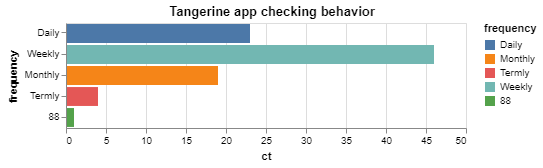

In [50]:
alt.Chart(tchk_freq, title="Tangerine app checking behavior").mark_bar().encode(
    alt.X("ct:Q"),
    alt.Y("frequency:O", sort = alt.EncodingSortField(field="sort_order:Q", op="values", order="ascending")),
    color = "frequency")

### CSO reference to the Tangerine Dashboard

_In the last term, how often did you look at the Tangerine Dashboard?_

The data that is generated by the CSOs' lesson observations is uploaded to the cloud and reported on the [Tangerine Dashboard](http://tools.tusome.tangerinecentral.org/_csv/report/group-national_tablet_program/00b0a09a-2a9f-baca-2acb-c6264d4247cb,c835fc38-de99-d064-59d3-e772ccefcf7d/2018/1/ep8yqMKT.html#tutor). This Dashboard is reviewed by senior management within the Ministry of Education: the Principal Secretary, his Directors, and their deputies. It is also sent to the Directors of MOE and TSC at the County level. As these latter personnel oversee the CSOs, the Dashboard may have an effect ...

In [51]:
ip=get_ipython()
locate_dir = ip.ipython_dir
profile_dir = ip.config.ProfileDir.location
print("IPython location: %s" % locate_dir)
print("IPython profile location: %s" % profile_dir)


IPython location: C:\Users\tslade\.ipython
IPython profile location: <traitlets.config.loader.LazyConfigValue object at 0x000001922F72D358>


In [52]:
import os
extra_paths = ip.config.NotebookApp['extra_static_paths']
static_paths = os.path.join(profile_dir,'static')
if type( extra_paths ) is list:
    static_paths = extra_paths + static_paths
print("The custom.js file will be searched in this list of directories: %s" % static_paths)

TypeError: expected str, bytes or os.PathLike object, not LazyConfigValue

In [53]:
static_paths = os.path.join(profile_dir,'static')

TypeError: expected str, bytes or os.PathLike object, not LazyConfigValue

In [ ]:
import os
import re
for static_path in static_paths:
    custom_js = os.path.join(static_path,'custom', 'custom.js')
    if os.path.isfile(custom_js) is True:
        print("custom.js found in %s" % custom_js)
        break

In [ ]:
test = 91.1
int(test)

In [ ]:
tab_usage.tab_usage.mode()